# 深度循环神经网络 Deep RNN

在简单RNN/LSTM中，单隐藏层结构已能处理许多序列任务，但随着任务复杂度提升（如视频理解、文档摘要），其缺陷日益显著：

- 特征抽象不足：单层隐藏状态需同时编码低级语法（如词性）和高级语义（如情感倾向），导致信息过载。

- 长程依赖衰减：即便LSTM有门控机制，超长序列中关键信息仍可能在多层时间传递后稀释。

- 模式识别单一：时序动态与空间特征的联合建模能力有限（如无法同时捕捉视频中的动作和物体）。

*单层记忆结构如同试图用一台收音机同时接收所有频道——信号混杂，难以分辨。*

深度RNN的核心思想：层次化时序特征

- 底层：捕捉局部模式（如单词/帧级别的变化）。

- 中层：组合局部模式为片段语义（如句子/动作片段）。

- 高层：建模全局依赖（如段落/视频主题）。

下面是一个简单的深度循环神经网络

In [1]:
import torch

# 在 torch.nn.RNN 里面可以设定 num_layers 来设置层数，如果层数 > 1 返回的模型就是深度循环神经网络
# 来测试一下输出
num_layers = 3

model = torch.nn.RNN(input_size=32, hidden_size=64, num_layers=num_layers, dropout=0.1, batch_first=True)

inputs = torch.randn(100, 20, 32)
hidden = torch.zeros(num_layers, 100, 64)

outputs, hidden = model(inputs, hidden)

# RNN 返回的是输出和每一层的隐藏状态
print(outputs.shape)
print(hidden.shape)

torch.Size([100, 20, 64])
torch.Size([3, 100, 64])


In [2]:
# 长短期记忆 torch.nn.LSTM 作为一种 RNN 也可以也设定 num_layers > 1 来实现深度循环神经网络

model = torch.nn.LSTM(input_size=32, hidden_size=64, num_layers=num_layers, dropout=0.1, batch_first=True)

inputs = torch.randn(100, 20, 32)
hidden = torch.zeros(num_layers, 100, 64)

outputs, (hidden, cell) = model(inputs)

# 和传统 RNN 不同的是，深度长短期记忆返回的是输出和每一层的隐藏状态与细胞状态

print(outputs.shape)
print(hidden.shape)
print(cell.shape)

torch.Size([100, 20, 64])
torch.Size([3, 100, 64])
torch.Size([3, 100, 64])


In [3]:
# 下面我们将手动实现一个深度循环神经网络

class RNN(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, inputs: torch.Tensor, hidden: torch.Tensor):
        outputs = []
        for i in inputs.unbind(1):
            combined = torch.cat([i, hidden], dim=-1)
            hidden = torch.tanh(self.i2h(combined))
            outputs.append(hidden)
        return torch.stack(outputs, dim=1), hidden


class DeepRNNCell(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, dropout: float | None = None):
        super().__init__()
        self.rnn = RNN(input_size, hidden_size)
        self.norm = torch.nn.LayerNorm(hidden_size)
        self.dropout = torch.nn.Dropout(dropout) if dropout and dropout > 0 else None

    def forward(self, inputs: torch.Tensor, hidden: torch.Tensor):
        outputs, hidden = self.rnn(inputs, hidden)
        outputs = self.norm(outputs)
        if self.dropout is not None:
            outputs = self.dropout(outputs)
        return outputs, hidden


class DeepRNN(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float | None = None):
        assert num_layers > 1
        super().__init__()
        self.layers = torch.nn.ModuleList([DeepRNNCell(input_size, hidden_size, dropout)])
        for _ in range(num_layers - 2):
            self.layers.append(DeepRNNCell(hidden_size, hidden_size, dropout))
        # dropout 是概率随机丢失参数，层间加入 dropout 为了防止过拟合。最后一层不加 dropout 增加输出稳定性
        self.layers.append(DeepRNNCell(hidden_size, hidden_size))

    def forward(self, inputs: torch.Tensor, input_hiddens: torch.Tensor):
        outputs = inputs
        output_hiddens = []
        for i, cell in enumerate(self.layers):
            outputs, hidden = cell(outputs, input_hiddens[i])
            output_hiddens.append(hidden)
        return outputs, torch.stack(output_hiddens, dim=0)

In [4]:
model = DeepRNN(input_size=32, hidden_size=64, num_layers=3, dropout=0.1)

inputs = torch.randn(100, 20, 32)
hidden = torch.zeros(num_layers, 100, 64)

outputs, hidden = model(inputs, hidden)

print(outputs.shape)
print(hidden.shape)

torch.Size([100, 20, 64])
torch.Size([3, 100, 64])


# 大语言模型的雏形

我们将用上面的模型训练一个~并不~大语言模型。

语言模型的第一步是词嵌入 Embedding 它的作用是使词转换成张量以方便模型处理

假如我们使用分词器解码 `"蛙鼠战争"` 得到了编码 `[1,2,3]`

为了将词编码转换成词向量，我们很容易就想到了下面的编码方式

```
"蛙" → [1, 0, 0]
"鼠" → [0, 1, 0]
"战争" → [0, 0, 1]
```

这种方法是**独热编码 One-Hot Encoding**，简单且易实现。

但是问题也很明显:

维度灾难	词表增长导致向量维度爆炸，每个词都是一个维度。

语义盲区	所有词向量正交，无法表达相似性。"蛙"与"鼠"的距离和"蛙"与"战争"的距离相同。

但是，独热编码确实成功的将词编码转换成词向量。为了避免维度灾难，我们可以将词向量通过线性层转换成低维度的向量。

这个就是目前通用的词嵌入。

*关于词向量的讨论在本项目代码库里实现，此处不进行展开。*

接下来会实现一个语言模型，模型里隐含了词向量的转换。

In [5]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.datasets import fetch_20newsgroups
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train_data = fetch_20newsgroups(subset="train")["data"][:512]
test_data = fetch_20newsgroups(subset="test")["data"][:16]

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer.decoder = decoders.WordPiece()
trainer = trainers.WordPieceTrainer(
    vocab_size=1000,  # 词汇表大小
    min_frequency=2,  # 最小出现频率
    special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"],  # 特殊token
    continuing_subword_prefix="##",  # 子词前缀
)

tokenizer.train_from_iterator(train_data, trainer=trainer)
output = tokenizer.encode("This is a test sentence.")
print(tokenizer.decode(output.ids))

This is a test sentence.


In [7]:
# 电脑内存不足只能单批训练了（悲）

def build_dataset(data: list[str], tokenizer: Tokenizer, device=DEVICE):
    end_token = tokenizer.get_vocab()["[EOS]"]
    dataset: list[tuple[torch.Tensor, torch.Tensor]] = []
    for text in tqdm(data, desc="build_dataset"):
        tokenized = tokenizer.encode(text).ids
        dataset.append(
            (
                torch.tensor(tokenized, dtype=torch.long, device=device).unsqueeze(0),
                torch.tensor(tokenized[1:] + [end_token], dtype=torch.long, device=device).unsqueeze(0),
            )
        )
    return dataset


train_dataset = build_dataset(train_data, tokenizer)
test_dataset = build_dataset(test_data, tokenizer)

build_dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1652.20it/s]


In [8]:
num_layers = 3
emb_size = 50
hidden_size = 128


class ChatDeepRNN(torch.nn.Module):
    def __init__(self, tokenizer: Tokenizer):
        super().__init__()
        self.vocab = tokenizer.get_vocab()
        self.vocab_size = len(self.vocab)
        self.end_token = self.vocab["[EOS]"]
        self.emb = torch.nn.Embedding(self.vocab_size, emb_size)
        self.deep_rnn = DeepRNN(emb_size, hidden_size, num_layers, 0.1)
        self.lm = torch.nn.Linear(hidden_size, self.vocab_size)

    def forward(self, inputs: torch.Tensor, hiddens: torch.Tensor):
        embeddings = self.emb(inputs)
        outputs, hiddens = self.deep_rnn(embeddings, hiddens)
        return self.lm(outputs), hiddens

    @torch.no_grad()
    def generate(self, context: str, max_new_tokens: int = 4096, device=DEVICE):
        context_tensor = torch.tensor(tokenizer.encode(context).ids, dtype=torch.long, device=device).unsqueeze(0)
        hiddens = torch.zeros((num_layers, 1, hidden_size), device=device)
        logits, hiddens = self(context_tensor, hiddens)
        probs = torch.softmax(logits.squeeze(0)[-1], dim=-1)
        idx = torch.multinomial(probs, num_samples=1)
        out = context_tensor.squeeze(0).tolist()
        out.append(idx.item())
        for _ in range(max_new_tokens):
            logits, hiddens = self(idx.unsqueeze(0), hiddens)
            probs = torch.softmax(logits.squeeze(0)[-1], dim=-1)
            idx = torch.multinomial(probs, num_samples=1)
            if (ix := idx.item()) == self.end_token:
                break
            out.append(ix)
        return tokenizer.decode(out)

    @torch.no_grad()
    def evaluate(self, dataloader: DataLoader, device=DEVICE):
        all_predis = []
        for tensors, labels in tqdm(dataloader, desc="evaluate"):
            batch_size = tensors.size(0)
            hiddens = torch.zeros((num_layers, batch_size, hidden_size), device=DEVICE)
            logits, _ = self(tensors, hiddens)
            predis = torch.argmax(logits, dim=-1)
            all_predis.append((predis == labels).float().mean().item())
        return sum(all_predis) / len(all_predis)

In [9]:
model = ChatDeepRNN(tokenizer).to(DEVICE)
model.generate("in school", 128)

'in school n bitar net themase caru bitlyDUotork anyoneologentrg pointwayri Pro amK<< seem 0 >ink LinesE )ertther confulle cr 10 newON86gr!ticle th wayost $ + also - 13 ):9V it-=-=cc any reallyervribimimware ve has comm decrg -/: afterru usedc overack +"ith [re} 4dz theseystem this there grad much?? ). that.. Sh thosefuluchibleations 1 Nntp 14ious\\/ opets zple couldiansissur Year pe 34atherays what that9.) would'

In [10]:
import random

iters = 10

lossi = []

print("initial accuracy:", model.evaluate(test_dataset))

optimizer = torch.optim.Adam(model.parameters())

for epoch in range(iters):
    random.shuffle(train_dataset)
    for tensors, labels in tqdm(train_dataset, desc=f"epoch {epoch}"):
        batch_size = labels.size(0)
        hiddens = torch.zeros((num_layers, batch_size, hidden_size), device=DEVICE)
        logits, _ = model(tensors, hiddens)
        loss = torch.nn.functional.cross_entropy(logits.view(-1, model.vocab_size), labels.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss)
    print("accuracy:", model.evaluate(test_dataset))

evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.57it/s]


initial accuracy: 0.001540881406981498


evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


accuracy: 0.09781537228263915


evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.29it/s]


accuracy: 0.13217297662049532


evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.53it/s]


accuracy: 0.14226875407621264


evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.24it/s]


accuracy: 0.15859564300626516


evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.00it/s]


accuracy: 0.1631593992933631


evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.73it/s]


accuracy: 0.17355893924832344


evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


accuracy: 0.17702160961925983


evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.91it/s]


accuracy: 0.18295715656131506


evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.24it/s]


accuracy: 0.18452817108482122


evaluate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.62it/s]

accuracy: 0.1882994184270501


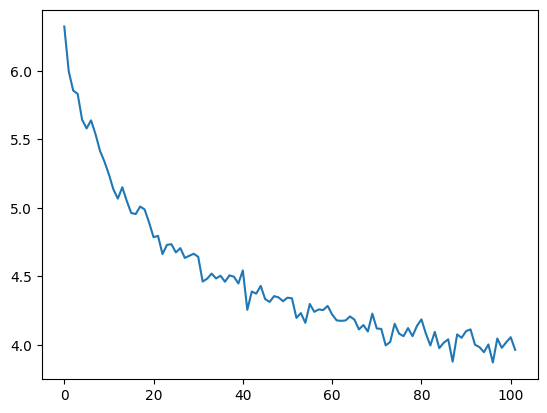

In [11]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(lossi[: len(lossi) // 50 * 50]).view(-1, 50).mean(dim=-1))
plt.show()

In [12]:
model.generate("we are", 128)

'we are looking to >> in telps it if the Net ) H) I can be >> the monand means old >> back : better cost own aride it is to alone menver right that the TR was colorsing about D OrganizationT Technology force has God herestoysevigill Arodio ( Steke ) Subject : Re : Corpapsers, CA Lines : 11 NNTP - Posting - Host : jiostway ( reconeighth - accped to > just caseltre'

In [13]:
# 有点逻辑，但不多。
torch.save(model, "ChatDeepRNN.pth")

In [14]:
model.generate("in school", 128)

'in school, and ATwer just for an anfeation their who use of the sepons - Ecussarhoalse flthspt, and such not you was lot to Rtration to price. I guess in poreination, case traround coided. It partail At a him proter. ray. datee ( Set LiaX\\ 8- Al Shain, Binding Lines : 0 All. 851468 - 0700 - 5 Rick hamb'